VASICEK MODEL

Define functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
np.seterr(all="ignore")
plt.rcParams['figure.figsize'] = [11.69, 8.27]
plt.rcParams['font.size'] = 17

In [2]:
# let's create a function which takes as input Vasicek model parameters and
# return an array
# with zero-coupon bond prices at different maturities

def zero_coupon(tao, r0, kappa, theta, sigma):
    
    B = (1 - np.exp(-kappa * tao)) / kappa
    A = (theta - sigma**2 / (2*kappa**2)) * (B - tao) -\
        (sigma**2 / (4 * kappa)) * B ** 2
        
    
    n2 = len(A)
    A_ = A
    B_ = B
    r_ = np.repeat(r0, n2)
    
    p = np.exp(A_ - B_ * r_)
    return p

In [3]:
# Let's create a function which, given the array of zero-coupon
# bond prices, returns the corresponding yields

def model_yield(mat, p):
    
    Y = np.zeros((len(mat),))
    for i in range(len(mat)):
        Y[i] = -np.log(p[int(mat[i]*12)]) / mat[i]
        
    return Y

In [4]:
# Let's build our objective function, the function which
# is going to be minimized in the optimization

def obj_func(params, tao, mat):
    #unpack params
    r0 = params[0]
    kappa = params[1]
    theta = params[2]
    sigma = params[3]
    
    p = zero_coupon(tao, r0, kappa, theta, sigma)
    
    # Now we have zero-coupon bond prices p (t, T)
    # hence let's compute Model rates
    Y = model_yield(mat, p)
    
    # let's minimize the distance between model rates and market rates
    # divide yields in the ECB input table by 100, as in the table
    # they are expressed in %
    sqe_yield = (Y- ECB[:,1] / 100)**2
    sqe_yield_sum = sqe_yield.sum()
    
    return sqe_yield_sum

In [5]:
# Constraints to fix r0, and to force kappa and sigma to be positive

def constraint0(x):
    return x[0] - r0_fixed
def constraint1(x):
    return x[1]
def constraint2(x):
    return x[3]

In [6]:
def calibration(starting_param, tao, mat, ECB):
    
    np.set_printoptions(suppress=True)
    opt = {"maxiter":1000}
    cons = [{"type" : "eq", "fun" : constraint0}, {"type" : "ineq",
                                                   "fun" : constraint1},
            {"type" : "ineq", "fun" : constraint2}]
    sol = minimize(obj_func, starting_param, args = (tao, mat), 
                   options=opt, constraints = cons)
    #print(sol.message) 
    par = np.array(sol.x)
    #print("parameters = " + str(par))
    r_star = par[0]
    kappa_star = par[1]
    theta_star = par[2]
    sigma_star = par[3]
    
    return obj_func(par, tao, mat), par

Inputs

In [7]:
# Calibration date 27/01/2022

# Yields are in % (ECB AAA yields)
ECB = np.array([
    [3/12, -0.732515],
    [6/12, -0.729880],
    [9/12, -0.722188],
    [12/12, -0.710373],
    [24/12, -0.636188],
    [36/12, -0.542129],
    [48/12, -0.446193],
    [60/12, -0.356722],
    [72/12, -0.276936],
    [84/12, -0.207454],
    [96/12, -0.147671],
    [108/12, -0.096495],
    [120/12, -0.052711],
    [11, -0.015167],
    [12, 0.017160],
    [13, 0.045140],
    [14, 0.069500],
    [15, 0.090840],
    [16, 0.109649],
    [17, 0.126327],
    [18, 0.141201],
    [19, 0.154539],
    [20, 0.166560],
    [21, 0.177448],
    [22, 0.187352],
    [23, 0.196399],
    [24, 0.204694],
    [25, 0.212327],
    [26, 0.219373],
    [27, 0.225898],
    [28, 0.231958],
    [29, 0.237599],
    [30, 0.242865]
])

# r0 = first point in ECB array
r0_fixed = ECB[0,1] / 100

# tao array for the zero-coupon curve, from 0 to 30 years every month
tao = np.arange(0, 30 + 1/12, 1/12)

# Maturities of ECB yields (first column)
mat = ECB[:,0]

Model Calibration

In [8]:
# Number of simulations
N = 1000000

# Create a result matrix (N x 5), with N rows (number of simulated starting
# parameters) and 5 columns (the first one is the sum of the squared 
# relative errors, and the following four are: r0, kappa, theta and sigma)

results = np.zeros((N,5))

for i in range(0,N):
    starting_param = np.array([np.random.uniform(-0.05, 0.05),
                               np.random.uniform(0.01, 0.30), 
                               np.random.uniform(-0.05, 0.05),
                               np.random.uniform(0.001, 0.13)])
    
    sqe, params = calibration(starting_param, tao, mat, ECB)
    
    results[i,0] = sqe
    results[i,1] = params[0]
    results[i,2] = params[1]
    results[i,3] = params[2]
    results[i,4] = params[3]

In [9]:
top10_params = np.zeros((10,5))
j = 0
for i in np.argsort(results[:,0])[0:10]:
    top10_params[j,:] = results[i,:]
    j += 1

top10_params

array([[ 0.00000272, -0.00732515,  0.02776427,  0.05899564,  0.01183581],
       [ 0.00000273, -0.00732515,  0.02660326,  0.06144127,  0.01175298],
       [ 0.00000273, -0.00732515,  0.02826226,  0.0581252 ,  0.01190214],
       [ 0.00000273, -0.00732515,  0.02612151,  0.06274445,  0.0117527 ],
       [ 0.00000273, -0.00732515,  0.02662353,  0.06140687,  0.01175915],
       [ 0.00000273, -0.00732515,  0.02887852,  0.05680232,  0.01191671],
       [ 0.00000273, -0.00732515,  0.02739977,  0.05965991,  0.01178643],
       [ 0.00000273, -0.00732515,  0.02848629,  0.05765841,  0.01191711],
       [ 0.00000273, -0.00732515,  0.02854447,  0.05729575,  0.01186053],
       [ 0.00000273, -0.00732515,  0.02651991,  0.06178103,  0.01178064]])

In [10]:
# Set of optimized parameters
opt_params = top10_params[:,1:].mean(axis = 0)
opt_params

array([-0.00732515,  0.02752038,  0.05959109,  0.01182642])

In [11]:
r0_star = top10_params[:,1:].mean(axis = 0)[0]
theta_star = top10_params[:,1:].mean(axis = 0)[1] 
kappa_star = top10_params[:,1:].mean(axis = 0)[2]
sigma_star = top10_params[:,1:].mean(axis = 0)[3]

In [12]:
# ZCB
p_model = zero_coupon(tao, r0_star, kappa_star, theta_star, sigma_star)

# Monodimensional array
model_yields = model_yield(ECB[:,0], p_model)*100

In [13]:
# Delete results to free up RAM
del results

Plots

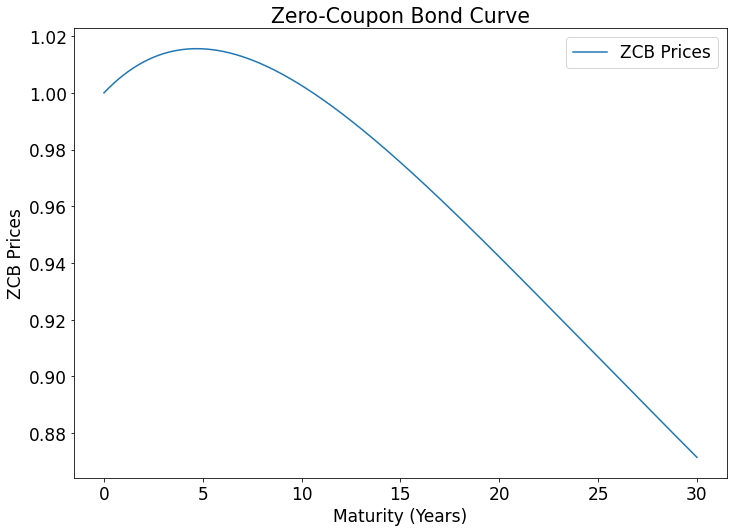

In [14]:
plt.plot(tao, p_model, label = "ZCB Prices")
plt.xlabel("Maturity (Years)")
plt.ylabel("ZCB Prices")
plt.title("Zero-Coupon Bond Curve")
plt.legend()
plt.savefig("Zero-Coupon Bond Curve", dpi = 1800)
plt.show()

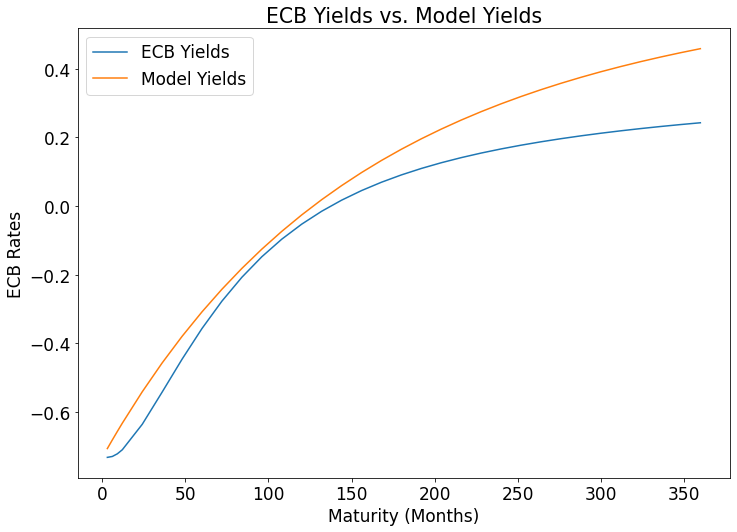

In [15]:
plt.plot(mat*12, ECB[:, 1], label = "ECB Yields")
plt.plot(mat*12, model_yields, label = "Model Yields")
plt.legend(loc="best")
plt.title("ECB Yields vs. Model Yields")
plt.xlabel("Maturity (Months)")
plt.ylabel("ECB Rates")
plt.savefig("ECB yields vs. Model yields.png", dpi = 1800)
plt.show()